/Users/dariusgiannoli/Desktop/Recognition-BenchMark/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🤖 Initializing MobileViT-XXS on mps...


/Users/dariusgiannoli/Desktop/Recognition-BenchMark/venv/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Loaded MobileViT head from /Users/dariusgiannoli/Desktop/Recognition-BenchMark/models/mobilevit_head.pkl

🚀 Starting Scan with MobileViT-XXS...

🔬 BENCHMARK: MobileViT-XXS
Total Time:      7.1126s
Latency/Window:  11.6219ms
Detections:      8


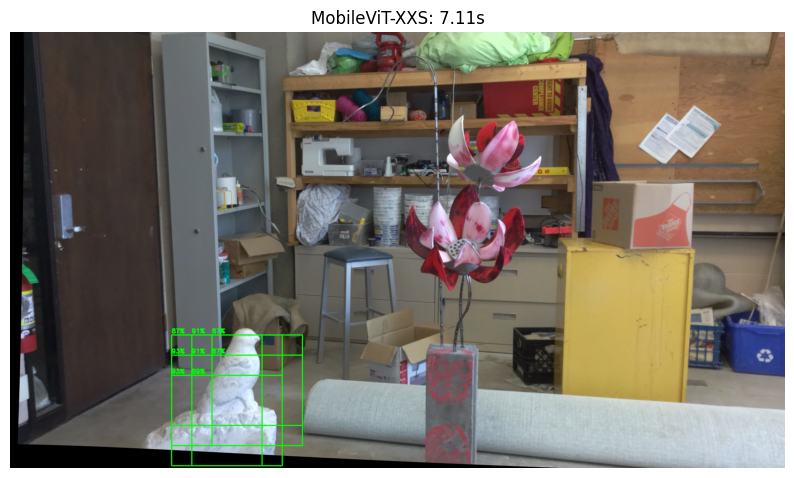

In [1]:
import sys
import os
import cv2
import time
import matplotlib.pyplot as plt
from pathlib import Path

# 1. Setup Path
PROJECT_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PROJECT_ROOT))

from src.detectors.mobilevit import MobileViTDetector

# ====================================================
# 2. DEFINE SCANNER (Inline for safety)
# ====================================================
class BruteForceScanner:
    def __init__(self, step_size=50, window_size=(224, 224), conf_threshold=0.85):
        self.step_size = step_size
        self.window_size = window_size
        self.conf_threshold = conf_threshold

    def run(self, image, model, model_name="Unknown"):
        window_w, window_h = self.window_size
        detections = []
        total_windows = 0
        
        print(f"\n🚀 Starting Scan with {model_name}...")
        t0 = time.perf_counter()

        for y in range(0, image.shape[0] - window_h, self.step_size):
            for x in range(0, image.shape[1] - window_w, self.step_size):
                total_windows += 1
                window = image[y:y + window_h, x:x + window_w]
                
                # PREDICT
                label, conf, _ = model.predict(window)
                
                if label == 'bird' and conf > self.conf_threshold:
                    detections.append((x, y, conf))

        t1 = time.perf_counter()
        total_time = t1 - t0
        
        return {
            "model": model_name,
            "detections": detections,
            "total_windows": total_windows,
            "total_time_sec": total_time,
            "ms_per_window": (total_time / total_windows) * 1000 if total_windows > 0 else 0
        }
    
    def visualize(self, image, results):
        img_copy = image.copy()
        for (x, y, conf) in results['detections']:
            cv2.rectangle(img_copy, (x, y), (x + 224, y + 224), (0, 255, 0), 2)
            cv2.putText(img_copy, f"{conf:.0%}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
        plt.title(f"{results['model']}: {results['total_time_sec']:.2f}s")
        plt.axis('off')
        plt.show()

# ====================================================
# 3. RUN BENCHMARK
# ====================================================
img_path = PROJECT_ROOT / "data/artroom/im0.png"
img = cv2.imread(str(img_path))

if img is not None:
    try:
        # Load Model
        model = MobileViTDetector()
        
        # Run Scan
        scanner = BruteForceScanner(step_size=50)
        results = scanner.run(img, model, model_name="MobileViT-XXS")
        
        # Print Stats
        print("\n" + "="*40)
        print(f"🔬 BENCHMARK: {results['model']}")
        print("="*40)
        print(f"Total Time:      {results['total_time_sec']:.4f}s")
        print(f"Latency/Window:  {results['ms_per_window']:.4f}ms")
        print(f"Detections:      {len(results['detections'])}")
        print("="*40)
        
        scanner.visualize(img, results)
        
    except Exception as e:
        print(f"❌ Error: {e}")
        print("Did you run 'python training/train_mobilevit.py'?")